In [49]:
from imports import *

In [50]:
def create_biased_qgb_circuit(levels, theta= np.pi / 9):
    """
    Create a biased Quantum Galton Board circuit.
    - levels: number of levels (integer >= 1)
    - theta: rotation angle around X-axis on control qubit (float)
             theta=pi/2 ~ balanced (like Hadamard), smaller/larger biases the distribution
    """
    assert levels >= 1, "Levels must be >= 1"
    total_qubits = 2 * levels + 2
    ball = levels + 1

    quantum_circ = QuantumCircuit(total_qubits, levels + 1)

    # Initial biased superposition on control qubit q0
    quantum_circ.rx(theta, 0)
    quantum_circ.x(ball)

    ball_positions = [ball]

    for step in range(levels):
        quantum_circ.reset(0)
        quantum_circ.rx(theta, 0)  # biased rotation instead of Hadamard

        new_positions = set()
        positions_this_step = sorted(ball_positions)

        for i, pos in enumerate(positions_this_step):
            left = pos - 1
            right = pos + 1

            if left >= 1 and right < total_qubits:
                quantum_circ.cswap(0, left, pos)
                quantum_circ.cx(pos, 0)
                quantum_circ.cswap(0, pos, right)

                if step >= 1 and i < len(positions_this_step) - 1:
                    quantum_circ.cx(right, 0)

                new_positions.update([left, right])

        ball_positions = sorted(new_positions)

    # Measure odd qubits as usual
    measure_qubits = [i for i in range(1, total_qubits, 2)]
    for i, q in enumerate(measure_qubits[:levels + 1]):
        quantum_circ.measure(q, i)

    return quantum_circ

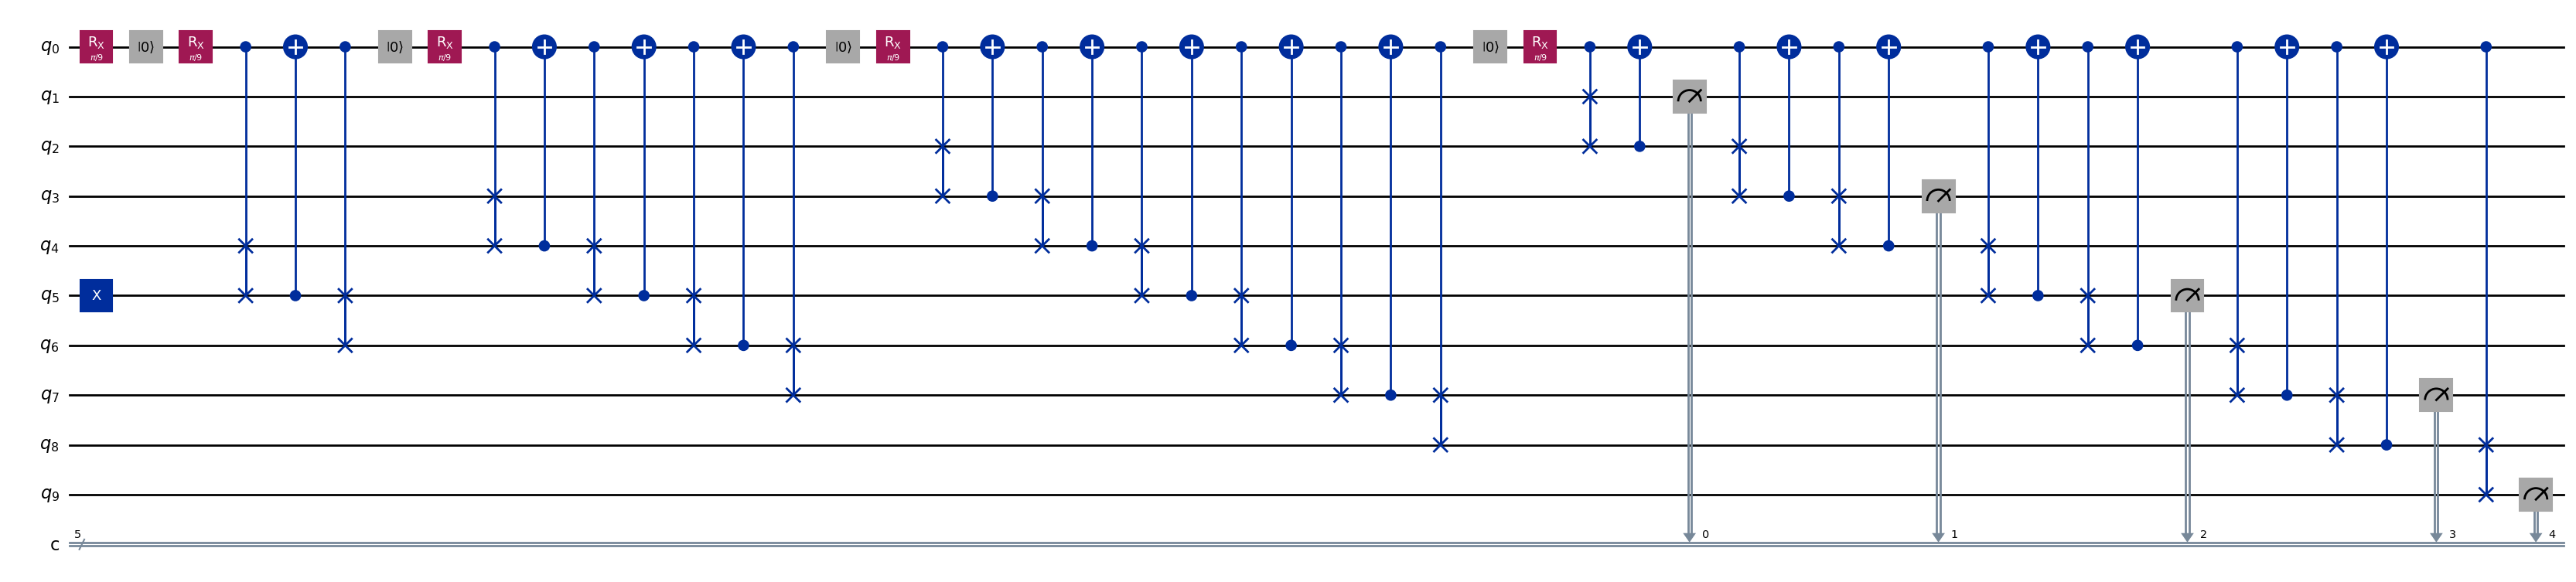

In [51]:
quantum_circ = create_biased_qgb_circuit(4)
quantum_circ.draw('mpl', fold = -1)

Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.
Total shots: 20000, Mapped shots: 20000, Unknown patterns: 0

Single-shot mapped statistics (values in {0,1,2,3,4}):
  Mean     = 0.119300
  Std dev  = 0.343181
  Variance = 0.117773

Per-position counts (0..4):
  pos 0: 17739
  pos 1: 2138
  pos 2: 121
  pos 3: 2
  pos 4: 0

Number of full blocks of 8: 2500
Printing every block (index: [values] -> sum):

Block     1: [0, 0, 0, 0, 0, 0, 1, 1]  -> sum = 2
Block     2: [1, 0, 0, 1, 0, 1, 0, 0]  -> sum = 3
Block     3: [0, 0, 0, 0, 0, 0, 0, 0]  -> sum = 0
Block     4: [0, 0, 0, 0, 0, 0, 0, 0]  -> sum = 0
Block     5: [0, 1, 0, 0, 0, 0, 0, 0]  -> sum = 1
Block     6: [0, 0, 1, 2, 0, 0, 0, 0]  -> sum = 3
Block     7: [1, 0, 0, 0, 0, 0, 0, 0]  -> sum = 1
Block     8: [0, 0, 0, 0, 1, 0, 0, 0]  -> sum = 1
Block     9: [0, 0, 0, 0, 0, 0, 0, 0]  -> sum = 0
Block    10: [0, 0, 0, 0, 0, 0, 0, 1]  -> sum = 1
Block    11: [0, 0, 1, 0, 0, 0, 1, 0]  -> sum = 2
Block

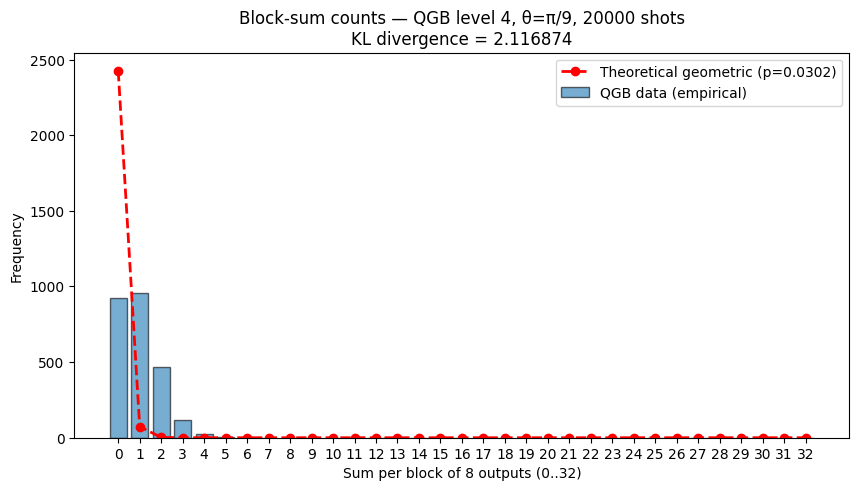

In [53]:
from scipy.stats import entropy
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)  # use 1 for speed; change to 3 if you want heavy optimization
qc_transpiled = pass_manager.run(quantum_circ)


# Run with memory=True if possible (so we get per-shot bitstrings)
job = backend.run(qc_transpiled, shots=20000, memory=True)
result = job.result()

# --- robust extraction of per-shot bitstrings (as strings) ---
shot_bitstrings = None

# Try a few common ways to get the shot memory:
try:
    # new Aer result API
    shot_bitstrings = result.get_memory(0)   # usually returns list of bitstrings (strings)
except Exception:
    pass

if shot_bitstrings is None:
    # Sometimes memory is under results[0].data.memory
    try:
        shot_bitstrings = result.results[0].data.memory
    except Exception:
        pass

if shot_bitstrings is None:
    # Fallback: expand counts into a shot list (order will be arbitrary)
    try:
        counts = result.get_counts(0)
    except Exception:
        try:
            counts = result.results[0].data.counts
        except Exception:
            raise RuntimeError("Couldn't extract memory or counts from result. Check Qiskit/Aer version.")
    # expand counts -> list of strings
    shot_bitstrings = []
    for bitstr, c in counts.items():
        shot_bitstrings.extend([bitstr] * c)

# normalize bitstrings length (pad left with zeros if needed)
n_meas = quantum_circ.num_clbits  # expected 5 for level 4
shot_bitstrings = [s.rjust(n_meas, "0") for s in shot_bitstrings]

# --- detect endianness & mapping orientation ---
# target patterns (logical mapping): index -> pattern
target_patterns = {
    0: "00001",
    1: "00010",
    2: "00100",
    3: "01000",
    4: "10000"
}
pattern_set = set(target_patterns.values())

def count_matches(shot_list, reverse=False):
    total = 0
    for s in shot_list:
        key = s[::-1] if reverse else s
        if key in pattern_set:
            total += 1
    return total

matches_as_is = count_matches(shot_bitstrings, reverse=False)
matches_rev  = count_matches(shot_bitstrings, reverse=True)
reverse_flag = True if matches_rev >= matches_as_is else False
# choose orientation producing more matches
if reverse_flag:
    print("Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.")
else:
    print("Detected bitstring orientation: normal (no reverse).")

# build mapping: pattern -> int
pattern_to_int = {v: k for k, v in target_patterns.items()}

# --- map each shot to integer 0..4; collect unknowns separately ---
mapped_values = []
unknowns = Counter()
for s in shot_bitstrings:
    key = s[::-1] if reverse_flag else s
    if key in pattern_to_int:
        mapped_values.append(pattern_to_int[key])
    else:
        unknowns[key] += 1

mapped_values = np.array(mapped_values, dtype=int)
N_mapped = mapped_values.size
print(f"Total shots: {len(shot_bitstrings)}, Mapped shots: {N_mapped}, Unknown patterns: {sum(unknowns.values())}")

if sum(unknowns.values()) > 0:
    # show a few unexpected keys to help debugging
    print("Examples of unexpected measured bitstrings (will be ignored):")
    for idx, (k, v) in enumerate(unknowns.most_common(10)):
        print(f"  '{k}': {v} times")
    print("If many unknowns appear, check measurement order / circuit mapping.")

# --- statistics on single-shot mapped values ---
if N_mapped == 0:
    raise RuntimeError("No mapped shots available. Cannot compute statistics.")
mean_val = mapped_values.mean()
std_val = mapped_values.std(ddof=1) if N_mapped > 1 else float('nan')
var_val = mapped_values.var(ddof=1) if N_mapped > 1 else float('nan')

print("\nSingle-shot mapped statistics (values in {0,1,2,3,4}):")
print(f"  Mean     = {mean_val:.6f}")
print(f"  Std dev  = {std_val:.6f}")
print(f"  Variance = {var_val:.6f}")

# show per-position frequency
pos_counts = Counter(mapped_values)
print("\nPer-position counts (0..4):")
for p in range(5):
    print(f"  pos {p}: {pos_counts.get(p,0)}")

# --- BLOCKS of 8: print each block and its sum ---
if N_mapped < 8:
    raise RuntimeError("Not enough mapped shots to form a single block of 8.")

n_blocks = N_mapped // 8
trimmed = mapped_values[:n_blocks * 8]
blocks = trimmed.reshape(n_blocks, 8)
block_sums = blocks.sum(axis=1)

print(f"\nNumber of full blocks of 8: {n_blocks}")
print("Printing every block (index: [values] -> sum):\n")
for i, block in enumerate(blocks, start=1):
    print(f"Block {i:5d}: {block.tolist()}  -> sum = {int(block_sums[i-1])}")

# --- frequency of sums 0..32 and plot ---

# --- frequency of sums 0..32 and plot ---
sum_counts = Counter(block_sums)
freqs = np.array([sum_counts.get(s, 0) for s in range(33)], dtype=float)

# Theoretical geometric (discrete exponential) distribution
theta = np.pi / 9
p = np.sin(theta / 2)**2   # probability of moving "right" at each step
N_blocks = freqs.sum()     # total number of blocks

k_vals = np.arange(33)
theoretical_probs = (1 - p) * (p ** k_vals)         # ideal probabilities
theoretical_counts = theoretical_probs * N_blocks  # scale to counts

# --- KL divergence ---
# Normalize to probability distributions
empirical_probs = freqs / N_blocks
# Add a tiny epsilon to avoid log(0)
eps = 1e-12
empirical_probs = np.clip(empirical_probs, eps, 1)
theoretical_probs = np.clip(theoretical_probs, eps, 1)
kl_divergence = entropy(empirical_probs, theoretical_probs)  # D_KL(P||Q)

print(f"\nKL divergence between empirical and theoretical = {kl_divergence:.6f} bits (log base e)")

# --- Plot ---
plt.figure(figsize=(10,5))
plt.bar(k_vals, freqs, edgecolor='black', alpha=0.6, label='QGB data (empirical)')
plt.plot(k_vals, theoretical_counts, 'r--', lw=2, marker='o',
         label=f'Theoretical geometric (p={p:.4f})')

plt.xlabel("Sum per block of 8 outputs (0..32)")
plt.ylabel("Frequency")
plt.title(f"Block-sum counts — QGB level 4, θ=π/9, {len(shot_bitstrings)} shots\nKL divergence = {kl_divergence:.6f}")
plt.xticks(range(0,33,1))
plt.legend()
plt.show()

# sum_counts = Counter(block_sums)
# freqs = [sum_counts.get(s, 0) for s in range(33)]

# print("\nBlock-sum frequencies (0..32):")
# for s, f in enumerate(freqs):
#     print(f" sum {s:2d}: {f}")

# # plot histogram (33 bins: 0..32)
# plt.figure(figsize=(10,5))
# plt.bar(range(33), freqs, edgecolor='black')
# plt.xlabel("Sum per block of 8 outputs (0..32)")
# plt.ylabel("Frequency")
# plt.title(f"Block-sum counts (0..32) — QGB level 4, {len(shot_bitstrings)} shots (mapped: {N_mapped})")
# plt.xticks(range(0,33,1))
# plt.show()


#### **Changing the angles at each rotation**

In [57]:
def create_biased_qgb_circuit(levels, thetas=None):
    """
    Create a biased Quantum Galton Board circuit with different angles per rotation.

    Parameters:
        levels: int, number of levels (>=1)
        thetas: list or None
            - If list: must have length = levels+1 (initial + one per step)
            - If None: defaults to all pi/9
    """
    assert levels >= 1, "Levels must be >= 1"

    # Default: same angle each time
    if thetas is None:
        thetas = [np.pi / 9] * (levels + 1)
    else:
        assert len(thetas) == levels + 1, f"Expected {levels+1} angles, got {len(thetas)}"

    total_qubits = 2 * levels + 2
    ball = levels + 1

    quantum_circ = QuantumCircuit(total_qubits, levels + 1)

    # Initial biased superposition on control qubit q0
    quantum_circ.rx(thetas[0], 0)
    quantum_circ.x(ball)

    ball_positions = [ball]

    for step in range(levels):
        quantum_circ.reset(0)
        quantum_circ.rx(thetas[step + 1], 0)  # different bias per step

        new_positions = set()
        positions_this_step = sorted(ball_positions)

        for i, pos in enumerate(positions_this_step):
            left = pos - 1
            right = pos + 1

            if left >= 1 and right < total_qubits:
                quantum_circ.cswap(0, left, pos)
                quantum_circ.cx(pos, 0)
                quantum_circ.cswap(0, pos, right)

                if step >= 1 and i < len(positions_this_step) - 1:
                    quantum_circ.cx(right, 0)

                new_positions.update([left, right])

        ball_positions = sorted(new_positions)

    # Measure odd qubits as usual
    measure_qubits = [i for i in range(1, total_qubits, 2)]
    for i, q in enumerate(measure_qubits[:levels + 1]):
        quantum_circ.measure(q, i)

    return quantum_circ


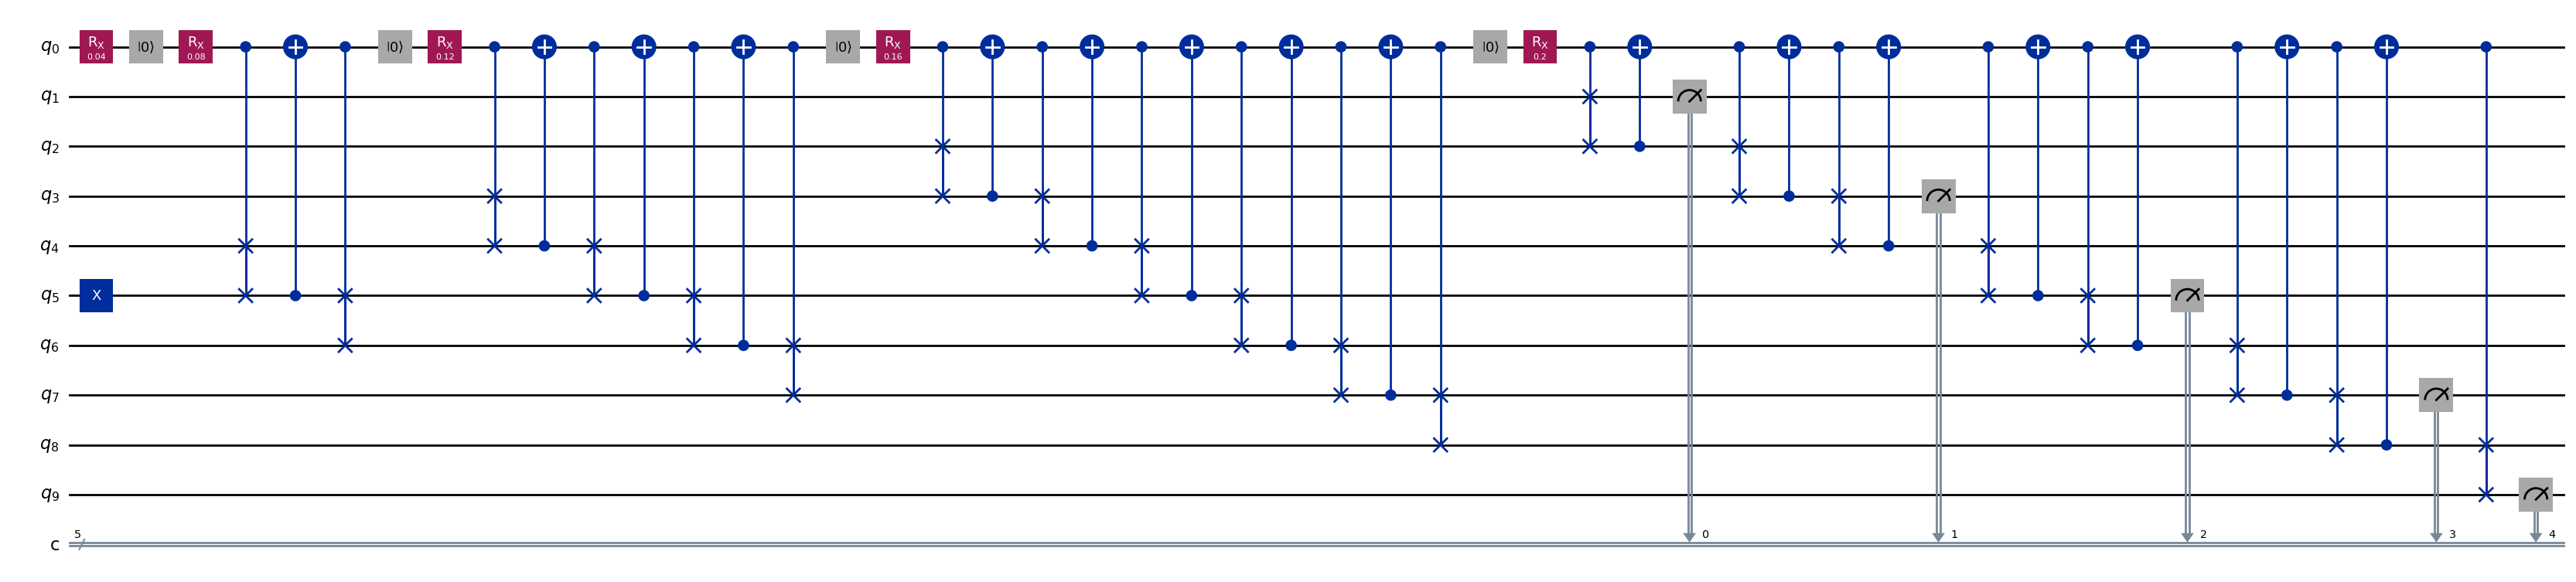

In [78]:
a = 0.04
angles = [a , 2 * a, 3 * a, 4 * a, 5 * a]
quantum_circ = create_biased_qgb_circuit(levels=4, thetas=angles)
quantum_circ.draw('mpl', fold = -1)

Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.
Total shots: 20000, Mapped shots: 20000, Unknown patterns: 0

Single-shot mapped statistics (values in {0,1,2,3,4}):
  Mean     = 0.021150
  Std dev  = 0.145271
  Variance = 0.021104

Per-position counts (0..4):
  pos 0: 19581
  pos 1: 415
  pos 2: 4
  pos 3: 0
  pos 4: 0

Number of full blocks of 8: 2500
Printing every block (index: [values] -> sum):

Block     1: [0, 0, 0, 0, 0, 0, 0, 0]  -> sum = 0
Block     2: [0, 0, 0, 1, 0, 0, 0, 0]  -> sum = 1
Block     3: [0, 0, 0, 0, 0, 0, 0, 0]  -> sum = 0
Block     4: [0, 0, 0, 0, 0, 0, 0, 0]  -> sum = 0
Block     5: [0, 0, 0, 0, 0, 0, 0, 0]  -> sum = 0
Block     6: [0, 0, 0, 0, 0, 0, 0, 0]  -> sum = 0
Block     7: [0, 0, 0, 0, 0, 0, 1, 0]  -> sum = 1
Block     8: [0, 0, 0, 0, 0, 0, 0, 0]  -> sum = 0
Block     9: [0, 0, 0, 0, 0, 0, 0, 0]  -> sum = 0
Block    10: [0, 0, 0, 0, 0, 0, 0, 0]  -> sum = 0
Block    11: [0, 0, 0, 0, 0, 0, 0, 0]  -> sum = 0
Block   

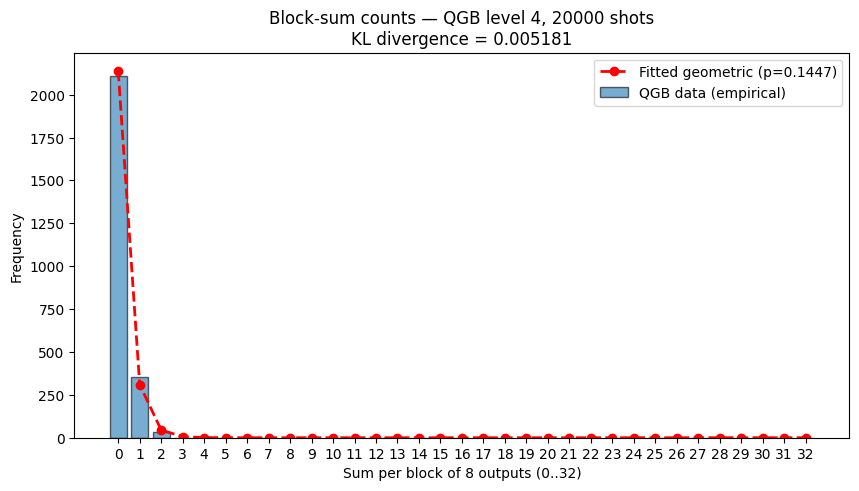

In [79]:
# from scipy.stats import entropy
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)  # use 1 for speed; change to 3 if you want heavy optimization
qc_transpiled = pass_manager.run(quantum_circ)


# Run with memory=True if possible (so we get per-shot bitstrings)
job = backend.run(qc_transpiled, shots=20000, memory=True)
result = job.result()

# --- robust extraction of per-shot bitstrings (as strings) ---
shot_bitstrings = None

# Try a few common ways to get the shot memory:
try:
    # new Aer result API
    shot_bitstrings = result.get_memory(0)   # usually returns list of bitstrings (strings)
except Exception:
    pass

if shot_bitstrings is None:
    # Sometimes memory is under results[0].data.memory
    try:
        shot_bitstrings = result.results[0].data.memory
    except Exception:
        pass

if shot_bitstrings is None:
    # Fallback: expand counts into a shot list (order will be arbitrary)
    try:
        counts = result.get_counts(0)
    except Exception:
        try:
            counts = result.results[0].data.counts
        except Exception:
            raise RuntimeError("Couldn't extract memory or counts from result. Check Qiskit/Aer version.")
    # expand counts -> list of strings
    shot_bitstrings = []
    for bitstr, c in counts.items():
        shot_bitstrings.extend([bitstr] * c)

# normalize bitstrings length (pad left with zeros if needed)
n_meas = quantum_circ.num_clbits  # expected 5 for level 4
shot_bitstrings = [s.rjust(n_meas, "0") for s in shot_bitstrings]

# --- detect endianness & mapping orientation ---
# target patterns (logical mapping): index -> pattern
target_patterns = {
    0: "00001",
    1: "00010",
    2: "00100",
    3: "01000",
    4: "10000"
}
pattern_set = set(target_patterns.values())

def count_matches(shot_list, reverse=False):
    total = 0
    for s in shot_list:
        key = s[::-1] if reverse else s
        if key in pattern_set:
            total += 1
    return total

matches_as_is = count_matches(shot_bitstrings, reverse=False)
matches_rev  = count_matches(shot_bitstrings, reverse=True)
reverse_flag = True if matches_rev >= matches_as_is else False
# choose orientation producing more matches
if reverse_flag:
    print("Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.")
else:
    print("Detected bitstring orientation: normal (no reverse).")

# build mapping: pattern -> int
pattern_to_int = {v: k for k, v in target_patterns.items()}

# --- map each shot to integer 0..4; collect unknowns separately ---
mapped_values = []
unknowns = Counter()
for s in shot_bitstrings:
    key = s[::-1] if reverse_flag else s
    if key in pattern_to_int:
        mapped_values.append(pattern_to_int[key])
    else:
        unknowns[key] += 1

mapped_values = np.array(mapped_values, dtype=int)
N_mapped = mapped_values.size
print(f"Total shots: {len(shot_bitstrings)}, Mapped shots: {N_mapped}, Unknown patterns: {sum(unknowns.values())}")

if sum(unknowns.values()) > 0:
    # show a few unexpected keys to help debugging
    print("Examples of unexpected measured bitstrings (will be ignored):")
    for idx, (k, v) in enumerate(unknowns.most_common(10)):
        print(f"  '{k}': {v} times")
    print("If many unknowns appear, check measurement order / circuit mapping.")

# --- statistics on single-shot mapped values ---
if N_mapped == 0:
    raise RuntimeError("No mapped shots available. Cannot compute statistics.")
mean_val = mapped_values.mean()
std_val = mapped_values.std(ddof=1) if N_mapped > 1 else float('nan')
var_val = mapped_values.var(ddof=1) if N_mapped > 1 else float('nan')

print("\nSingle-shot mapped statistics (values in {0,1,2,3,4}):")
print(f"  Mean     = {mean_val:.6f}")
print(f"  Std dev  = {std_val:.6f}")
print(f"  Variance = {var_val:.6f}")

# show per-position frequency
pos_counts = Counter(mapped_values)
print("\nPer-position counts (0..4):")
for p in range(5):
    print(f"  pos {p}: {pos_counts.get(p,0)}")

# --- BLOCKS of 8: print each block and its sum ---
if N_mapped < 8:
    raise RuntimeError("Not enough mapped shots to form a single block of 8.")

n_blocks = N_mapped // 8
trimmed = mapped_values[:n_blocks * 8]
blocks = trimmed.reshape(n_blocks, 8)
block_sums = blocks.sum(axis=1)

print(f"\nNumber of full blocks of 8: {n_blocks}")
print("Printing every block (index: [values] -> sum):\n")
for i, block in enumerate(blocks, start=1):
    print(f"Block {i:5d}: {block.tolist()}  -> sum = {int(block_sums[i-1])}")

# --- frequency of sums 0..32 and plot ---

# --- frequency of sums 0..32 and plot ---
sum_counts = Counter(block_sums)
freqs = np.array([sum_counts.get(s, 0) for s in range(33)], dtype=float)

k_vals = np.arange(33)
N_blocks = freqs.sum()

# MLE fit for p in geometric distribution P(k) = (1-p)p^k
mean_k = np.average(k_vals, weights=freqs)
p_hat = mean_k / (1 + mean_k)

# Theoretical geometric distribution with fitted p_hat
theoretical_probs = (1 - p_hat) * (p_hat ** k_vals)
theoretical_counts = theoretical_probs * N_blocks

# --- KL divergence ---
empirical_probs = freqs / N_blocks
eps = 1e-12
empirical_probs = np.clip(empirical_probs, eps, 1)
theoretical_probs = np.clip(theoretical_probs, eps, 1)
kl_divergence = entropy(empirical_probs, theoretical_probs)

print(f"\nFitted p = {p_hat:.6f}")
print(f"KL divergence between empirical and fitted theoretical = {kl_divergence:.6f} nats")

# --- Plot ---
plt.figure(figsize=(10,5))
plt.bar(k_vals, freqs, edgecolor='black', alpha=0.6, label='QGB data (empirical)')
plt.plot(k_vals, theoretical_counts, 'r--', lw=2, marker='o',
         label=f'Fitted geometric (p={p_hat:.4f})')

plt.xlabel("Sum per block of 8 outputs (0..32)")
plt.ylabel("Frequency")
plt.title(f"Block-sum counts — QGB level 4, {len(shot_bitstrings)} shots\nKL divergence = {kl_divergence:.6f}")
plt.xticks(range(0,33,1))
plt.legend()
plt.show()







# sum_counts = Counter(block_sums)
# freqs = [sum_counts.get(s, 0) for s in range(33)]

# print("\nBlock-sum frequencies (0..32):")
# for s, f in enumerate(freqs):
#     print(f" sum {s:2d}: {f}")

# # plot histogram (33 bins: 0..32)
# plt.figure(figsize=(10,5))
# plt.bar(range(33), freqs, edgecolor='black')
# plt.xlabel("Sum per block of 8 outputs (0..32)")
# plt.ylabel("Frequency")
# plt.title(f"Block-sum counts (0..32) — QGB level 4, {len(shot_bitstrings)} shots (mapped: {N_mapped})")
# plt.xticks(range(0,33,1))
# plt.show()
